<a href="https://colab.research.google.com/github/EnterTheBeginning/SmartHomeEnergyForecasting/blob/master/Feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Working 5:  How does it look like? The final code
Model Run. 
1 year data for prediction of day ahead.
Features: Month.
tsfresh.
In an ideal world. I want prediction of price of tommorow. Since the realtime pricing is a valuable model.   
Right now it's day ahead pricing but in near future it will be realtime pricing with factors of weather. and more. That will model will be more lucrative. Since the real time pricing is even better. The ability to predict the day ahead price will come in handy since with the use of smart scheduling we can have the machines use the least Cost/H to the time of scheduling. 
The goal right now is finding a price data. For year 2017 massachesuet. In CSV format. adding the weather data. Build a model that has features of weekends, weekdays. And after that. We can use energy consumption model not to predict but to classify the dishwasher working hour. The data is better off to be in hours. The dishwasher has the ability to start 1 out of 24 hours. to 3 out of 24 hours. With 3 times a day. I need to find which classifer is used more. Then after the prediction of 24 hours of price i need to classify which hours are the cheapest. Then send the python notification command 
> Dishwasher be loaded before 6 or before 12  classifier 1 - 24. After that the command will be send
> Start the dishwasher around 2 at night or around 5. Profile [cheapet] [Economy][Tailored]
>Voila the smart home system is working now.

Worked on the prediciton of the price of tommorow It needs to be done on short range. And Input. 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model

from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten
from keras.layers import  Conv1D, MaxPool1D, Dense, Activation, GlobalMaxPool1D
from keras.utils import np_utils
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/1. DataAnalytics/~Code/Data/house15m.csv',index_col='Date & Time',parse_dates=['Date & Time'])
weather = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/1. DataAnalytics/~Code/Data/FweatherClean.csv',index_col='time')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Feature: Time

In [0]:
df_hour = df.resample('h').mean() 
df_day = df.resample('d').mean()
df_month = df.resample('m').mean()

In [0]:
#Energy our basic feature
energy = df_hour["Usage [kW]"]
energy =energy.reshape(energy.shape[0],1)

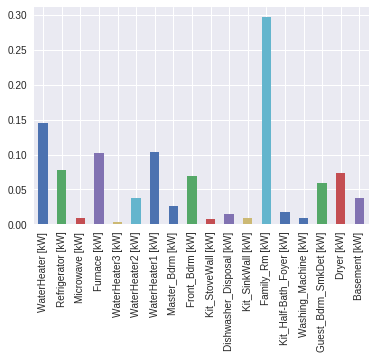

In [0]:
df.iloc[:,2:-2].mean().plot(kind='bar')

##Categorical Features: Season, month, day


In [0]:
season = np.array_split(df_hour,4)
  

In [0]:
month = np.array_split(df_hour, 12)


In [0]:
day = np.array_split(df,365)

### Preprocess 10 day prediction


In [0]:
## 10 days prediction with 20 days of data
split = 24*20
X = month[11]
X_train = X.iloc[:split,4:-2].values
y_train = X.iloc[:split,0].values

X_test = X.iloc[split:,4:-2].values
y_test = X.iloc[split:,0].values

y_train = X.iloc[:split,0].values
y_test = X.iloc[split:,0].values

In [0]:
training_set = X.iloc[:split,0:1].values
test_set = X.iloc[split:,0:1].values
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)

In [0]:
X_train = []
y_train = []
for i in range(24,480):
    X_train.append(training_set_scaled[i-24:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(24,217):
    X_test.append(test_set_scaled[i-24:i,0])
    y_test.append(test_set_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1]))

###Preprocess 24 hour prediciton

In [0]:
#24 hour energy prediction with 15m data
hour24 = int(df.shape[0] / 366)
split = 365*hour24

X = df.iloc[:split,0:1].values
y = df.iloc[:split,0:1].values
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(X)
test_set_scaled = sc.fit_transform(y)

In [0]:
X_train = []
y_train = []
for i in range(24,480):
    X_train.append(training_set_scaled[i-24:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(24,120):
    X_test.append(test_set_scaled[i-24:i,0])
    y_test.append(test_set_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

# DNN:

In [0]:
model = Sequential()
model.add(Dense(output_dim = 20, init = 'uniform', activation = 'relu', input_dim = 24))
model.add(Dense(output_dim = 35, init = 'uniform', activation = 'relu'))
model.add(Dense(output_dim = 1, init = 'uniform', activation = 'linear'))
model.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mean_absolute_error'])
model.fit(X_train, y_train, batch_size = 6, nb_epoch = 10, shuffle=0)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
456/456 [==============================] - 0s 865us/step - loss: 0.0582 - mean_absolute_error: 0.0582
Epoch 2/10
456/456 [==============================] - 0s 216us/step - loss: 0.0464 - mean_absolute_error: 0.0464
Epoch 3/10
456/456 [==============================] - 0s 222us/step - loss: 0.0443 - mean_absolute_error: 0.0443
Epoch 4/10
456/456 [==============================] - 0s 202us/step - loss: 0.0407 - mean_absolute_error: 0.0407
Epoch 5/10
456/456 [==============================] - 0s 225us/step - loss: 0.0343 - mean_absolute_error: 0.0343
Epoch 6/10
456/456 [==============================] - 0s 203us/step - loss: 0.0280 - mean_absolute_error: 0.0280
Epoch 7/10
456/456 [==============================] - 0s 193us/step - loss: 0.0253 - mean_absolute_error: 0.0253
Epoch 8/10
456/456 [==============================] - 0s 212us/step - loss: 0.0251 - mean

In [0]:
prediction = model.predict(X_test)
score = model.evaluate(X_test,y_test,verbose =0)
print('Test Loss:', score[0])
print('Test accuracy:' , score[1])
prediction = sc.inverse_transform(prediction)


Test Loss: 0.02511872009684642
Test accuracy: 0.02511872009684642


Text(0.5, 0, '120 Hour Prediction  ')

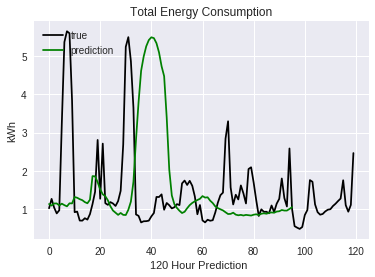

In [0]:
plt.figure(1)
plt.plot(test_set[:120],label='true',color = 'black')
plt.legend(loc='upper left')
plt.title('Total Energy Consumption')
plt.ylabel('kWh') 
plt.xlabel('120 Hour Prediction  ')

#LSTM

LSTM with 100 neurons in the first visible layer
The final output is the Energy usage 
Start

##LSTM Data Preparation

Scaling:

In [0]:
#24 hour energy prediction with 15m data
hour24 = int(df.shape[0] / 366)
split = 365*hour24

X = df.iloc[:split,0:1].values
y = df.iloc[:split,0:1].values
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(X)
test_set_scaled = sc.fit_transform(y)

In [0]:
X_train = []
y_train = []
for i in range(24,480):
    X_train.append(training_set_scaled[i-24:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(24,120):
    X_test.append(test_set_scaled[i-24:i,0])
    y_test.append(test_set_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [0]:
print('y_test:', y_test.shape)
print('X_train:' , X_train.shape)


y_test: (96,)
X_train: (456, 24)


In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


##Model:

In [0]:
model = Sequential()
layers = [1, 50,100, 1]
model.add(LSTM(layers[1],input_shape=(None, layers[0]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(layers[2],return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(layers[3]))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
model.fit(X_train, y_train,batch_size=16, nb_epoch=10, validation_split=0.05)


Train on 433 samples, validate on 23 samples
Epoch 1/10
433/433 [==============================] - 3s 7ms/step - loss: 0.0049 - acc: 0.0162 - val_loss: 0.0176 - val_acc: 0.0000e+00
Epoch 2/10
433/433 [==============================] - 1s 2ms/step - loss: 0.0034 - acc: 0.0162 - val_loss: 0.0121 - val_acc: 0.0000e+00
Epoch 3/10
433/433 [==============================] - 1s 2ms/step - loss: 0.0029 - acc: 0.0162 - val_loss: 0.0165 - val_acc: 0.0000e+00
Epoch 4/10
433/433 [==============================] - 1s 2ms/step - loss: 0.0025 - acc: 0.0162 - val_loss: 0.0052 - val_acc: 0.0000e+00
Epoch 5/10
433/433 [==============================] - 1s 2ms/step - loss: 0.0025 - acc: 0.0162 - val_loss: 0.0107 - val_acc: 0.0000e+00
Epoch 6/10
433/433 [==============================] - 1s 2ms/step - loss: 0.0023 - acc: 0.0162 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 7/10
433/433 [==============================] - 1s 2ms/step - loss: 0.0020 - acc: 0.0162 - val_loss: 0.0077 - val_acc: 0.0000e+00
Epo

In [0]:
prediction = model.predict(X_test)
score = model.evaluate(X_test,y_test,verbose =0)
print('Test Loss:', score[0])
print('Test accuracy:' , score[1])


Test Loss: 0.0017549683495114248
Test accuracy: 0.0


###Graph

Text(0.5, 0, 'Next 200 Hours')

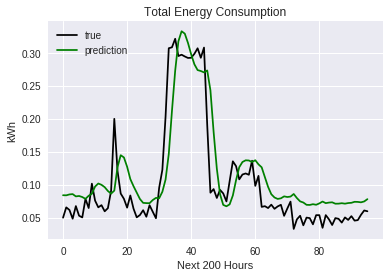

In [0]:
plt.figure(1)
plt.plot(y_test,label='true',color = 'black')
plt.plot(prediction,label='prediction',color = 'green')
plt.legend(loc='upper left')
plt.title('Total Energy Consumption')
plt.ylabel('kWh') 
plt.xlabel('')

Since the goal of this research is about prediction under uncertainty.  